# Classification

In [1]:
# niet vergeten nagaan als we uiteindelijk alles gebruiken
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
import pandas as pd
import numpy as np
import seaborn as sns
import itertools
from math import floor
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

E0000 00:00:1731422460.600517  205882 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1731422460.605983  205882 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [ ]:
from tensorflow import keras
from tensorflow.keras import Sequential, layers, Input, models
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam

## Data exploration

In [2]:
# Load Fashion MNIST dataset
fashion_mnist = tf.keras.datasets.fashion_mnist
(all_train_images, all_train_labels), (test_images, test_labels) = fashion_mnist.load_data()

# Check dataset shape
print("Training data shape:", all_train_images.shape)
print("Testing data shape:", test_images.shape)

Training data shape: (60000, 28, 28)
Testing data shape: (10000, 28, 28)


In [3]:
class_names = ['tshirt', 'trouser', 'pullover', 'dress', 'coat',
               'sandal', 'shirt', 'sneaker', 'bag', 'boot']

Distribution of the classes

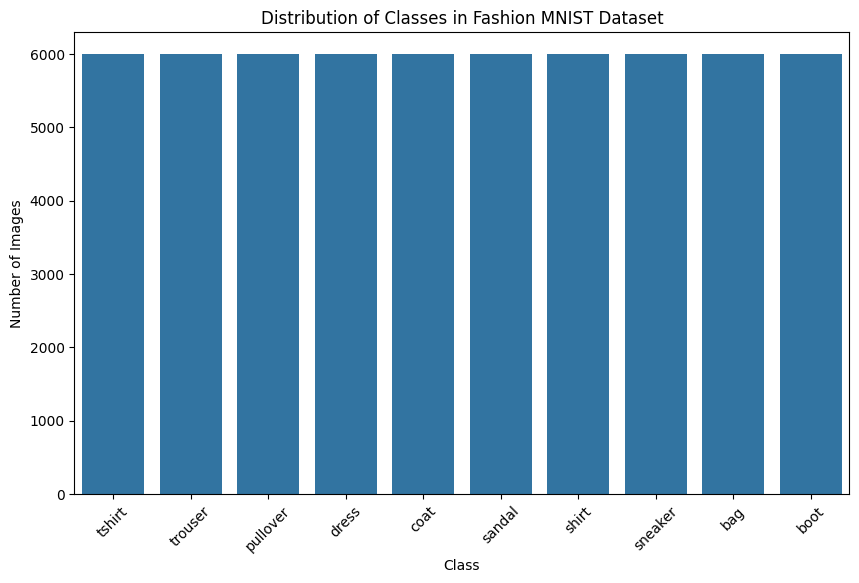

In [4]:
class_counts = np.bincount(all_train_labels)

plt.figure(figsize=(10, 6))
sns.barplot(x=class_names, y=class_counts)
plt.title("Distribution of Classes in Fashion MNIST Dataset")
plt.xlabel("Class")
plt.ylabel("Number of Images")
plt.xticks(rotation=45)
plt.show()

Plot a few samples

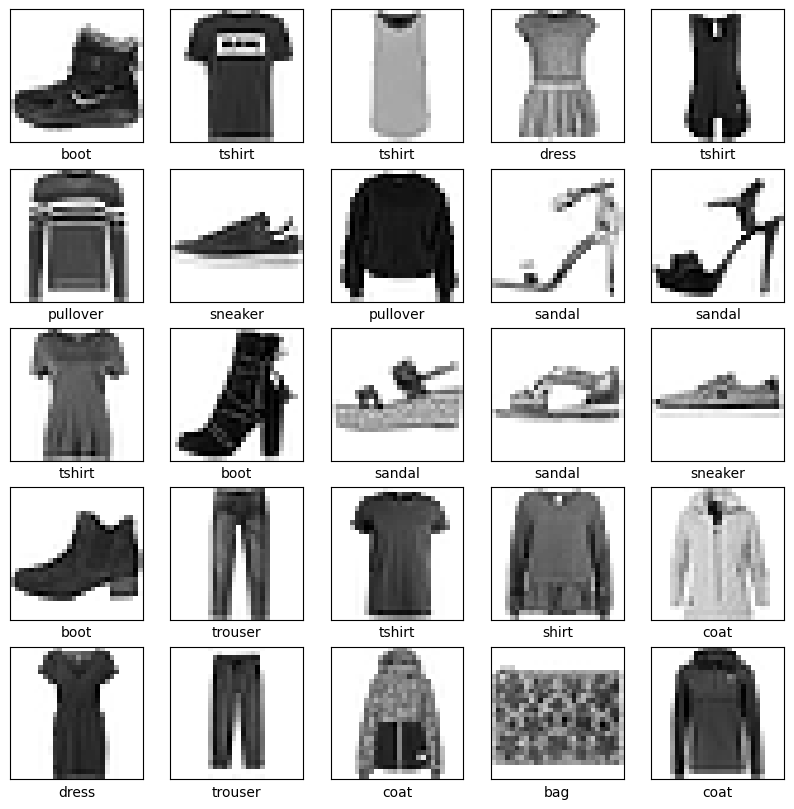

In [5]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(all_train_images[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[all_train_labels[i]])
plt.show()

Top-K Accuracy (e.g., Top-3 Accuracy)
Definition: Top-K accuracy measures whether the true label is among the top K predicted probabilities. For instance, in Top-3 accuracy, a prediction is considered correct if the true label is in the top 3 highest predicted probabilities.
Usefulness: Top-K accuracy is useful for problems with multiple acceptable answers or when near-misses are not considered total failures.
When to Use: This metric can be beneficial for Fashion MNIST if there’s tolerance for close-but-not-exact matches (e.g., if “Shirt” and “Tshirt” being close predictions is acceptable).

add this after layers are added: 
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=['accuracy', tf.keras.metrics.TopKCategoricalAccuracy(k=3)]
)

We can also use accuracy as always.
Accuracy= Number of Correct Predictions/Total Number of Predictions

add this after layers are added: 
model.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy']
              )

## Pre-processing

In [6]:
np.random.seed(1337)
tf.random.set_seed(1337)

In [7]:
image_size = all_train_images.shape[1]
print(image_size)

28


The images we work with are of size $28\times 28$, and we will prepare them by correcting them and normalizing their values. In addition, we will add an additional dimension to the images with a value of $1$ representing their channel (the images are black and white).

In [8]:
all_train_images = np.reshape(all_train_images, (-1, image_size, image_size, 1))
all_train_images = all_train_images.astype('float32') / 255

test_images = np.reshape(test_images, (-1, image_size, image_size, 1))
test_images = test_images.astype('float32') / 255

In [9]:
# Split the original training data into new training and validation sets
train_images, train_images_validation, train_labels, train_labels_validation = train_test_split(all_train_images, all_train_labels, test_size=0.2, random_state=42)

print("Training set size:", train_images.shape)
print("Validation set size:", train_images_validation.shape)
print("Test set size:", test_images.shape)

Training set size: (48000, 28, 28, 1)
Validation set size: (12000, 28, 28, 1)
Test set size: (10000, 28, 28, 1)


## Defining our initial model

In [10]:
# Ik ben niet zeker van de waarden 28 en 54
# In deeplearning 3 en 5 nemen ze 32 en 64, 32 wrs van input breedte en hoogte maar 64 geen idee wat de logica daarvan is

model = models.Sequential()

model.add(layers.Input(shape=(28, 28, 1)))
# We add a convolutional layer that has 28 3x3 filters with
# relu activation function.
model.add(layers.Conv2D(28, (3, 3), activation='relu'))
# We add a pooling layer that uses the maximum function
# where the filter size is 2x2.
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.1))

model.add(layers.Conv2D(56, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.1))

# deze is wrs niet meer nodig want de dim van max pooling is 1 op 1 want niet meer nuttig is
#model.add(layers.Conv2D(54, (3, 3), activation='relu'))
#model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Flatten())
model.add(layers.Dense(56, activation='relu'))
model.add(layers.Dense(10, activation='sigmoid'))

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 26, 26, 28)     │           280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 13, 13, 28)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 13, 13, 28)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 11, 11, 56)     │        14,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 5, 5, 56)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 5, 5, 56)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1400)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 56)             │        78,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │           570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 93,474 (365.13 KB)

 Trainable params: 93,474 (365.13 KB)

 Non-trainable params: 0 (0.00 B)

In [11]:
batch_size = 64
num_classes = 10

# Making the labels numerical is necessairy
all_train_labels_num = tf.keras.utils.to_categorical(all_train_labels, num_classes)
train_labels_num = tf.keras.utils.to_categorical(train_labels, num_classes)
train_labels_validation_num = tf.keras.utils.to_categorical(train_labels_validation, num_classes)
test_labels_num = tf.keras.utils.to_categorical(test_labels, num_classes)

print(f'train_labels.shape={train_labels.shape}')
print(f'test_labels.shape={test_labels.shape}')
print(f'test_labels.shape={train_labels_validation.shape}')
print(f'train_labels_num.shape={train_labels_num.shape}')
print(f'test_labels_num.shape={test_labels_num.shape}')
print(f'test_labels_num.shape={train_labels_validation_num.shape}')

model.compile( optimizer='adam', 
              loss=tf.keras.losses.CategoricalCrossentropy(), 
              metrics=['accuracy']) #, tf.keras.metrics.TopKCategoricalAccuracy(k=3)


train_labels.shape=(48000,)
test_labels.shape=(10000,)
test_labels.shape=(12000,)
train_labels_num.shape=(48000, 10)
test_labels_num.shape=(10000, 10)
test_labels_num.shape=(12000, 10)


## Training our model

In [12]:
epochs = 10
history = model.fit(
    train_images,
    train_labels_num,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(train_images_validation, train_labels_validation_num)
)

Epoch 1/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 11s 13ms/step - accuracy: 0.7229 - loss: 0.7923 - val_accuracy: 0.8518 - val_loss: 0.4110
Epoch 2/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - accuracy: 0.8610 - loss: 0.3888 - val_accuracy: 0.8718 - val_loss: 0.3539
Epoch 3/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - accuracy: 0.8785 - loss: 0.3337 - val_accuracy: 0.8885 - val_loss: 0.3086
Epoch 4/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 9s 13ms/step - accuracy: 0.8896 - loss: 0.3072 - val_accuracy: 0.8918 - val_loss: 0.2926
Epoch 5/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 9s 13ms/step - accuracy: 0.8996 - loss: 0.2776 - val_accuracy: 0.8938 - val_loss: 0.2907
Epoch 6/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - accuracy: 0.9047 - loss: 0.2610 - val_accuracy: 0.9000 - val_loss: 0.2701
Epoch 7/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - accuracy: 0.9062 - loss: 0.2545 - val_accuracy: 0.9062 - val_loss: 0.2577
Epoch 8/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - accuracy: 0.9151 - loss: 0.2293 - val_ac

In [13]:
val_accuracy = history.history['val_accuracy'][-1]
print(f"Validation accuracy: {val_accuracy:.4f}")

Validation accuracy: 0.9008


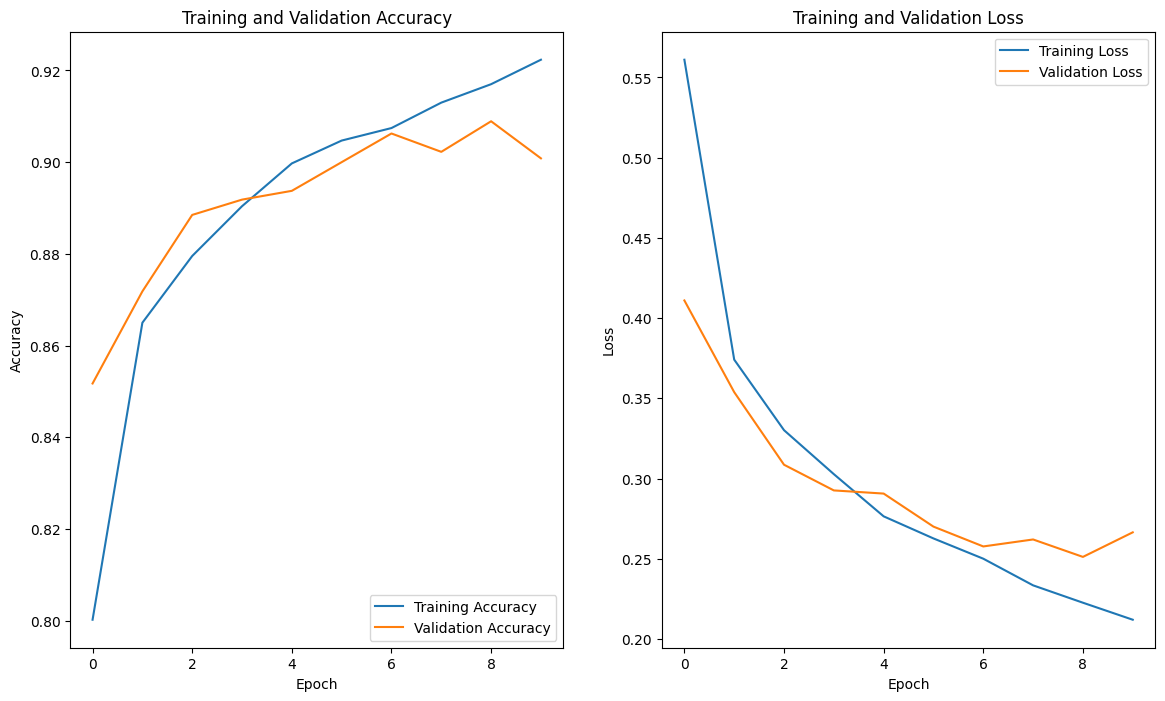

In [14]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(14, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

## Hyperparameter tuning

In [15]:
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

early_history = model.fit(train_images, train_labels_num, 
                    epochs=epochs, validation_split=0.2,
                    callbacks=[early_stop])

val_accuracy = early_history.history['val_accuracy'][-1]
print(f"Validation accuracy: {val_accuracy:.4f}")

Epoch 1/10
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.9139 - loss: 0.2287 - val_accuracy: 0.9250 - val_loss: 0.1968
Epoch 2/10
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - accuracy: 0.9233 - loss: 0.2034 - val_accuracy: 0.9255 - val_loss: 0.1964
Epoch 3/10
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - accuracy: 0.9265 - loss: 0.1929 - val_accuracy: 0.9183 - val_loss: 0.2180
Epoch 4/10
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - accuracy: 0.9332 - loss: 0.1815 - val_accuracy: 0.9275 - val_loss: 0.1958
Epoch 5/10
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.9335 - loss: 0.1727 - val_accuracy: 0.9250 - val_loss: 0.1968
Epoch 6/10
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - accuracy: 0.9375 - loss: 0.1665 - val_accuracy: 0.9108 - val_loss: 0.2329
Epoch 7/10
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - accuracy: 0.9382 - loss: 0.1624 - val_accuracy: 0.9149 - val_loss: 0.2245
Epoch 8/10
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.9447 - loss: 0.1487 -

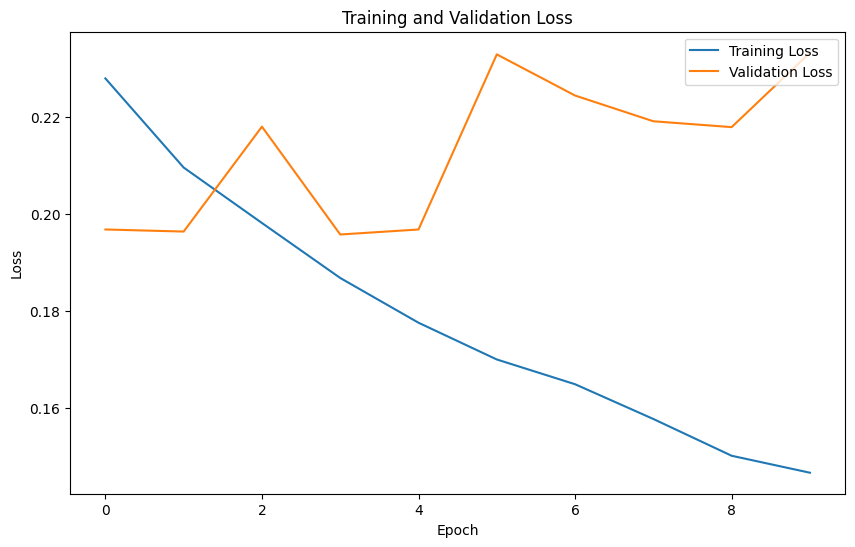

In [16]:
plt.figure(figsize=(10, 6))
plt.plot(early_history.epoch, early_history.history['loss'], label='Training Loss')
plt.plot(early_history.epoch, early_history.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [17]:
# das raar nu lijkt het alsof ons model aan het overfitten is

We will try to adjust our batch size and dropout rate to see which values give the best results.

In [18]:
model_new = Sequential([
    Input(shape=(28, 28, 1)),
    layers.Conv2D(28, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.1),
    layers.Conv2D(56, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.1),
    layers.Flatten(),
    layers.Dense(56, activation='relu'),
    layers.Dense(10, activation='sigmoid')
])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 26, 26, 28)     │           280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 13, 13, 28)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 13, 13, 28)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 11, 11, 56)     │        14,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 5, 5, 56)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 5, 5, 56)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1400)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 56)             │        78,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │           570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 280,424 (1.07 MB)

 Trainable params: 93,474 (365.13 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 186,950 (730.28 KB)

In [20]:
# Hyperparameter values to search
dropout_rates = [0, 0.1, 0.3]
batch_sizes = [32, 64, 128]

# Track results
results = {}

# Iterate over all combinations of dropout rate and batch size
for dropout_rate, batch_size in itertools.product(dropout_rates, batch_sizes):
    print(f"\nTraining model with dropout rate = {dropout_rate} and batch size = {batch_size}")
    
    # Define the model
    model_new = Sequential([
        Input(shape=(28, 28, 1)),
        layers.Conv2D(28, 3, padding='same', activation='relu'),
        layers.MaxPooling2D(),
        layers.Dropout(dropout_rate),  # Apply dropout rate here
        layers.Conv2D(56, 3, padding='same', activation='relu'),
        layers.MaxPooling2D(),
        layers.Dropout(dropout_rate),  # Apply dropout rate here
        layers.Flatten(),
        layers.Dense(56, activation='relu'),
        layers.Dense(10, activation='sigmoid')
    ])
    
    # Compile the model
    model_new.compile(
        optimizer='adam',
        loss=tf.keras.losses.CategoricalCrossentropy(),
        metrics=['accuracy']
    )

    # Train the model with the current hyperparameter combination
    history = model_new.fit(
        train_images, train_labels_num,
        batch_size=batch_size,
        epochs=10,
        validation_data=(train_images_validation, train_labels_validation_num)
        
    )
    
    # Record the validation accuracy of the last epoch
    val_accuracy = history.history['val_accuracy'][-1]
    results[(dropout_rate, batch_size)] = val_accuracy
    print(f"Validation accuracy: {val_accuracy:.4f}")

# Find the best combination based on validation accuracy
best_hyperparams = max(results, key=results.get)
print(f"\nBest hyperparameters: Dropout Rate = {best_hyperparams[0]}, Batch Size = {best_hyperparams[1]}")
print(f"Best validation accuracy: {results[best_hyperparams]:.4f}")


Training model with dropout rate = 0 and batch size = 32
Epoch 1/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 15s 9ms/step - accuracy: 0.7745 - loss: 0.6304 - val_accuracy: 0.8785 - val_loss: 0.3409
Epoch 2/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 13s 9ms/step - accuracy: 0.8909 - loss: 0.3101 - val_accuracy: 0.8997 - val_loss: 0.2742
Epoch 3/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 13s 9ms/step - accuracy: 0.9051 - loss: 0.2589 - val_accuracy: 0.9072 - val_loss: 0.2593
Epoch 4/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 14s 9ms/step - accuracy: 0.9206 - loss: 0.2160 - val_accuracy: 0.9106 - val_loss: 0.2447
Epoch 5/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 14s 9ms/step - accuracy: 0.9297 - loss: 0.1969 - val_accuracy: 0.9154 - val_loss: 0.2312
Epoch 6/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 14s 9ms/step - accuracy: 0.9394 - loss: 0.1673 - val_accuracy: 0.9149 - val_loss: 0.2361
Epoch 7/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 14s 9ms/step - accuracy: 0.9449 - loss: 0.1481 - val_accuracy: 0.9195 - val_loss: 0.2282
Epoch 8/10
1500/1500 ━━━━

In [21]:
# heb je andere ideen om hyperparameters te testen en te tweaken?  ma opzich ist eig al cv
# ik heb gemerkt dat ik super resultaten kan krijgen maar dan de test acc en train acc soms meer van elkaar beginnen verschillen (overfitten)
# heb ook al met verschillen de epochs gewerkt maar dat verandert het trainen niet veel blijft ong in zeflde lijnen

In [22]:
from tensorflow.keras import regularizers

# Define the model with L2 regularization and adjusted dropout
model_new = Sequential([
    Input(shape=(28, 28, 1)),
    
    # First Conv Layer with L2 regularization
    layers.Conv2D(28, 3, padding='same', activation='relu', 
                  kernel_regularizer=regularizers.l2(0.001)),
    layers.MaxPooling2D(),
    layers.Dropout(0.2),  # Increased dropout for added regularization
    
    # Second Conv Layer with L2 regularization
    layers.Conv2D(54, 3, padding='same', activation='relu', 
                  kernel_regularizer=regularizers.l2(0.001)),
    layers.MaxPooling2D(),
    layers.Dropout(0.3),  # Increased dropout for added regularization
    
    # Flatten and Dense Layers
    layers.Flatten(),
    layers.Dense(54, activation='relu', 
                 kernel_regularizer=regularizers.l2(0.001)),
    layers.Dropout(0.3),
    layers.Dense(10, activation='softmax')  # Softmax for classification
])

# Compile the model
model_new.compile(
    optimizer='adam',
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=['accuracy']
)

# Train the model
history = model_new.fit(
    train_images, train_labels_num,
    batch_size=64,
    epochs=10,
    validation_data=(train_images_validation, train_labels_validation_num)
)

val_accuracy = history.history['val_accuracy'][-1]
print(f"Validation accuracy: {val_accuracy:.4f}")

Epoch 1/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 13s 16ms/step - accuracy: 0.6834 - loss: 1.0333 - val_accuracy: 0.8592 - val_loss: 0.5138
Epoch 2/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 12s 16ms/step - accuracy: 0.8379 - loss: 0.5817 - val_accuracy: 0.8768 - val_loss: 0.4552
Epoch 3/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 12s 16ms/step - accuracy: 0.8522 - loss: 0.5326 - val_accuracy: 0.8802 - val_loss: 0.4407
Epoch 4/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 12s 16ms/step - accuracy: 0.8595 - loss: 0.5127 - val_accuracy: 0.8834 - val_loss: 0.4371
Epoch 5/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 12s 16ms/step - accuracy: 0.8693 - loss: 0.4863 - val_accuracy: 0.8776 - val_loss: 0.4422
Epoch 6/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 12s 16ms/step - accuracy: 0.8661 - loss: 0.4902 - val_accuracy: 0.8917 - val_loss: 0.4109
Epoch 7/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 12s 16ms/step - accuracy: 0.8719 - loss: 0.4734 - val_accuracy: 0.8931 - val_loss: 0.4094
Epoch 8/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 12s 16ms/step - accuracy: 0.8761 - loss: 0.4665 - 

Doesn't look like it helps, it's slightly worse.

In [23]:
results_df = pd.DataFrame(columns=[
    'run_id', 'batch_size', 'dropout_rate',
    'epochs', 'train_accuracy', 'val_accuracy', 'train_loss', 'val_loss'
])

In [24]:
run_id = 1
batch_size = 64
dropout_rate = 0.1
epochs = 10

# Compile the model
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=['accuracy']
)

# Train the model and store the results
history = model.fit(
    train_images, train_labels_num,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(train_images_validation, train_labels_validation_num)
)

# Log the performance metrics
train_accuracy = history.history['accuracy'][-1]
val_accuracy = history.history['val_accuracy'][-1]
train_loss = history.history['loss'][-1]
val_loss = history.history['val_loss'][-1]

# Create a new DataFrame for the current run
new_row = pd.DataFrame({
    'run_id': [run_id],
    'batch_size': [batch_size],
    'dropout_rate': [dropout_rate],
    'epochs': [epochs],
    'train_accuracy': [train_accuracy],
    'val_accuracy': [val_accuracy],
    'train_loss': [train_loss],
    'val_loss': [val_loss]
})

new_row = new_row.dropna(axis=1, how='all')

# Concatenate the new row with the existing DataFrame
results_df = pd.concat([results_df, new_row], ignore_index=True)

Epoch 1/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 11s 13ms/step - accuracy: 0.9446 - loss: 0.1544 - val_accuracy: 0.9120 - val_loss: 0.2592
Epoch 2/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - accuracy: 0.9482 - loss: 0.1385 - val_accuracy: 0.9112 - val_loss: 0.2562
Epoch 3/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - accuracy: 0.9497 - loss: 0.1312 - val_accuracy: 0.9155 - val_loss: 0.2585
Epoch 4/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - accuracy: 0.9525 - loss: 0.1276 - val_accuracy: 0.9165 - val_loss: 0.2568
Epoch 5/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - accuracy: 0.9518 - loss: 0.1257 - val_accuracy: 0.9089 - val_loss: 0.2835
Epoch 6/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - accuracy: 0.9542 - loss: 0.1225 - val_accuracy: 0.9123 - val_loss: 0.2749
Epoch 7/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - accuracy: 0.9573 - loss: 0.1130 - val_accuracy: 0.9137 - val_loss: 0.2638
Epoch 8/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - accuracy: 0.9578 - loss: 0.1095 - 

/tmp/ipykernel_205882/2930922418.py:42: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = pd.concat([results_df, new_row], ignore_index=True)


In [25]:
# Display the DataFrame to check the contents
print(results_df)

# Save the DataFrame to a CSV file
results_df.to_csv('../Data/model_run_results.csv', index=False)

  run_id batch_size  dropout_rate epochs  train_accuracy  val_accuracy  \
0      1         64           0.1     10        0.957125        0.9105   

   train_loss  val_loss  
0    0.111809  0.284649  


## Testing the final model

In [26]:
final_model = Sequential([
    Input(shape=(28, 28, 1)),
    layers.Conv2D(28, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(best_hyperparams[0]),
    layers.Conv2D(56, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(best_hyperparams[0]),
    layers.Flatten(),
    layers.Dense(56, activation='relu'),
    layers.Dense(10, activation='sigmoid')
])

final_model.summary()

Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_26 (Conv2D)              │ (None, 28, 28, 28)     │           280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_26 (MaxPooling2D) │ (None, 14, 14, 28)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_27 (Dropout)            │ (None, 14, 14, 28)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_27 (Conv2D)              │ (None, 14, 14, 56)     │        14,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_27 (MaxPooling2D) │ (None, 7, 7, 56)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_28 (Dropout)            │ (None, 7, 7, 56)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_13 (Flatten)            │ (None, 2744)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 56)             │       153,720 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 10)             │           570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 168,738 (659.13 KB)

 Trainable params: 168,738 (659.13 KB)

 Non-trainable params: 0 (0.00 B)

In [28]:
# Compile the model
final_model.compile(
    optimizer='adam',
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=['accuracy']
)

# Train the model with the current hyperparameter combination
final_history = final_model.fit(
    all_train_images, all_train_labels_num,
    batch_size=best_hyperparams[1],
    epochs=epochs,
    validation_data=(test_images, test_labels_num)
)

#waarom krijg ik een zeer raar resultaat als ik met steps per epoch werk?
    #all_train_images, all_train_labels_num,
    #batch_size=best_hyperparams[1],
    #steps_per_epoch=all_train_images.shape[0] // batch_size,
    #epochs=epochs,
    #validation_data=(test_images ,test_labels_num),
    #validation_steps=test_images.shape[0] // batch_size
    
# Record the validation accuracy of the last epoch
val_accuracy = final_history.history['val_accuracy'][-1]
print(f"Validation accuracy: {val_accuracy:.4f}")

Epoch 1/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 15s 15ms/step - accuracy: 0.7476 - loss: 0.6941 - val_accuracy: 0.8696 - val_loss: 0.3653
Epoch 2/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 14s 15ms/step - accuracy: 0.8796 - loss: 0.3392 - val_accuracy: 0.8858 - val_loss: 0.3110
Epoch 3/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 14s 15ms/step - accuracy: 0.8994 - loss: 0.2785 - val_accuracy: 0.9054 - val_loss: 0.2678
Epoch 4/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 14s 15ms/step - accuracy: 0.9056 - loss: 0.2540 - val_accuracy: 0.9082 - val_loss: 0.2557
Epoch 5/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 14s 15ms/step - accuracy: 0.9140 - loss: 0.2356 - val_accuracy: 0.9091 - val_loss: 0.2492
Epoch 6/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 14s 15ms/step - accuracy: 0.9228 - loss: 0.2129 - val_accuracy: 0.9116 - val_loss: 0.2432
Epoch 7/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 14s 15ms/step - accuracy: 0.9266 - loss: 0.1994 - val_accuracy: 0.9158 - val_loss: 0.2310
Epoch 8/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 14s 15ms/step - accuracy: 0.9330 - loss: 0.1791 - 

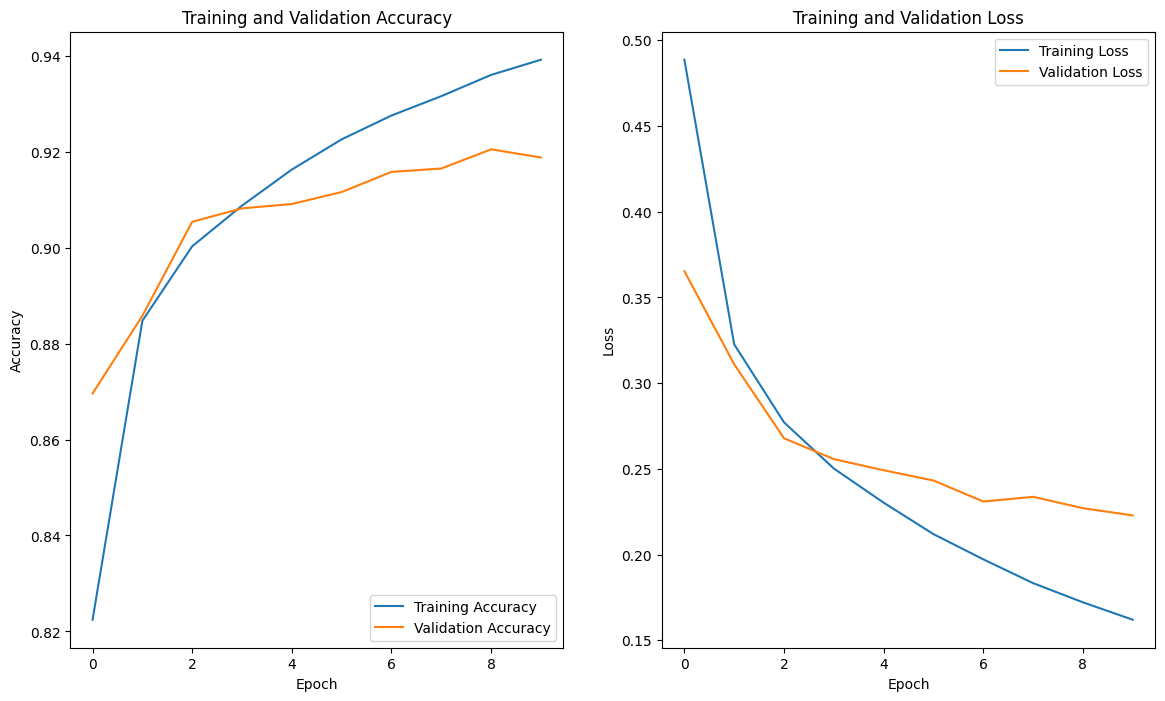

In [29]:
acc = final_history.history['accuracy']
val_acc = final_history.history['val_accuracy']

loss=final_history.history['loss']
val_loss=final_history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(14, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [30]:
# Evaluate the model on the test dataset
test_loss, test_accuracy = final_model.evaluate(test_images, test_labels_num)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

# Save the model weights to disk
final_model.save_weights('../Data/model.weights.h5')
print("Model weights have been saved to 'model.weights.h5'")

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9171 - loss: 0.2284
Test Loss: 0.2229
Test Accuracy: 0.9188
Model weights have been saved to 'model.weights.h5'


In [31]:
import yaml

# Dictionary containing your model configuration
config = {
    'model': {
        'architecture': [
            {'Conv2D': {'filters': 28, 'kernel_size': 3, 'padding': 'same', 'activation': 'relu'}},
            {'MaxPooling2D': {}},
            {'Dropout': {'rate': best_hyperparams[0]}},
            {'Conv2D': {'filters': 56, 'kernel_size': 3, 'padding': 'same', 'activation': 'relu'}},
            {'MaxPooling2D': {}},
            {'Dropout': {'rate': best_hyperparams[0]}},
            {'Flatten': {}},
            {'Dense': {'units': 56, 'activation': 'relu'}},
            {'Dense': {'units': 10, 'activation': 'sigmoid'}}
        ]
    },
    'training': {
        'epochs': 10,
        'batch_size': best_hyperparams[1],
        'loss': 'categorical_crossentropy',
        'optimizer': {'type': 'adam'},
        'metrics': ['accuracy']
    },
    'data': {
        'input_shape': [28, 28, 1],
        'num_classes': 10,
        'train_size': 60000,
        'val_size': 10000
    },
    'hyperparameters': {
        'batch_size': best_hyperparams[1],
        'dropout_rate': best_hyperparams[0]
    }
}

# Save the configuration to a YAML file
with open('../Data/training_config.yaml', 'w') as yaml_file:
    yaml.dump(config, yaml_file, default_flow_style=False)

print("Configuration saved to 'training_config.yaml'")


Configuration saved to 'training_config.yaml'


## Reconstruction

In [32]:
# Load the YAML configuration
with open('../Data/training_config.yaml', 'r') as file:
    config = yaml.safe_load(file)

# Display the loaded configuration (for debugging)
print(config)

{'data': {'input_shape': [28, 28, 1], 'num_classes': 10, 'train_size': 60000, 'val_size': 10000}, 'hyperparameters': {'batch_size': 64, 'dropout_rate': 0.1}, 'model': {'architecture': [{'Conv2D': {'activation': 'relu', 'filters': 28, 'kernel_size': 3, 'padding': 'same'}}, {'MaxPooling2D': {}}, {'Dropout': {'rate': 0.1}}, {'Conv2D': {'activation': 'relu', 'filters': 56, 'kernel_size': 3, 'padding': 'same'}}, {'MaxPooling2D': {}}, {'Dropout': {'rate': 0.1}}, {'Flatten': {}}, {'Dense': {'activation': 'relu', 'units': 56}}, {'Dense': {'activation': 'sigmoid', 'units': 10}}]}, 'training': {'batch_size': 64, 'epochs': 10, 'loss': 'categorical_crossentropy', 'metrics': ['accuracy'], 'optimizer': {'type': 'adam'}}}


In [63]:
def build_model(config):
    model = Sequential()

    model.add(layers.Input(shape=config['data']['input_shape']))

    # Build model from architecture in YAML
    for layer_config in config['model']['architecture']:
        for layer_type, params in layer_config.items():
            if layer_type == 'Conv2D':
                model.add(layers.Conv2D(filters=params['filters'],
                                        kernel_size=params['kernel_size'],
                                        padding=params['padding'],
                                        activation=params['activation']
                                       ))
            elif layer_type == 'MaxPooling2D':
                model.add(layers.MaxPooling2D())
            elif layer_type == 'Dropout':
                model.add(layers.Dropout(rate=params['rate']))
            elif layer_type == 'Flatten':
                model.add(layers.Flatten())
            elif layer_type == 'Dense':
                model.add(layers.Dense(units=params['units'], activation=params['activation']))
    
    return model

reconstruct_model = build_model(config)

optimizer = config['training']['optimizer']['type']
loss_name = config['training']['loss']
metrics = config['training']['metrics']

if loss_name == 'categorical_crossentropy':
    loss = tf.keras.losses.CategoricalCrossentropy()
else:
    raise ValueError(f"Unknown loss function: {loss_name}")

metrics_list = [metric for metric in metrics]

reconstruct_model.summary()

['accuracy']
accuracy


Model: "sequential_18"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_36 (Conv2D)              │ (None, 28, 28, 28)     │           280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_36 (MaxPooling2D) │ (None, 14, 14, 28)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_37 (Dropout)            │ (None, 14, 14, 28)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_37 (Conv2D)              │ (None, 14, 14, 56)     │        14,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_37 (MaxPooling2D) │ (None, 7, 7, 56)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_38 (Dropout)            │ (None, 7, 7, 56)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_18 (Flatten)            │ (None, 2744)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_36 (Dense)                │ (None, 56)             │       153,720 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_37 (Dense)                │ (None, 10)             │           570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 168,738 (659.13 KB)

 Trainable params: 168,738 (659.13 KB)

 Non-trainable params: 0 (0.00 B)

In [64]:
# Load the weights into the model
reconstruct_model.load_weights('../Data/model.weights.h5')

reconstruct_model.compile(
    optimizer=optimizer,
    loss=loss,
    metrics=metrics_list
)

# Verify the model's performance on the test set
test_loss, test_accuracy = reconstruct_model.evaluate(test_images, test_labels_num)
print(f'Test accuracy: {test_accuracy*100:.2f}%')

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9171 - loss: 0.2284
Test accuracy: 91.88%


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


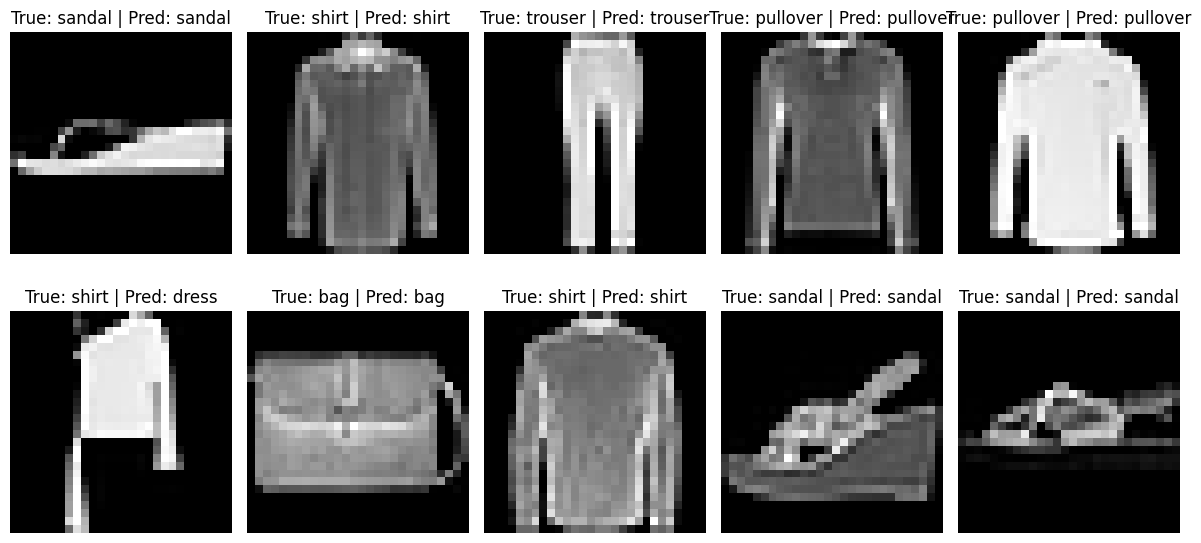

In [65]:
# Make predictions on the test set
predictions = model.predict(test_images)

# Get the predicted class labels (assuming the output is one-hot encoded)
predicted_labels = np.argmax(predictions, axis=1)

# Get the true labels (also one-hot encoded, convert them to class labels)
true_labels = np.argmax(test_labels_num, axis=1)

# Plot 10 random samples from the test set
num_samples = 10
random_indices = np.random.choice(range(test_images.shape[0]), size=num_samples, replace=False)

# Create a plot with random test samples and their labels
plt.figure(figsize=(12, 6))

for i, idx in enumerate(random_indices):
    plt.subplot(2, 5, i + 1)
    plt.imshow(test_images[idx].reshape(28, 28), cmap='gray')
    plt.title(f'True: {class_names[true_labels[idx]]} | Pred: {class_names[predicted_labels[idx]]}')
    plt.axis('off')

plt.tight_layout()
plt.show()